<a href="https://colab.research.google.com/github/alvinmhabieb/Credit_Scoring/blob/main/Credit_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Term deposits are a major source of income for a bank. A term deposit is a cash investment held at a financial institution. Your money is invested for an agreed rate of interest over a fixed amount of time, or term. The bank has various outreach plans to sell term deposits to their customers such as email marketing, advertisements, telephonic marketing, and digital marketing.

Telephonic marketing campaigns still remain one of the most effective way to reach out to people. However, they require huge investment as large call centers are hired to actually execute these campaigns. Hence, it is crucial to identify the customers most likely to convert beforehand so that they can be specifically targeted via call.

The data is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe to a term deposit (variable 'subscribed').

## Metadata

* Bank client data:

1. age (numeric)
2. job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
"blue-collar","self-employed","retired","technician","services")
3. marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
4. education (categorical: "unknown","secondary","primary","tertiary")
5. default: has credit in default? (binary: "yes","no")
6. balance: average yearly balance, in euros (numeric)
7. housing: has housing loan? (binary: "yes","no")
8. loan: has personal loan? (binary: "yes","no")

* Related with the last contact of the current campaign:
9. contact: contact communication type (categorical: "unknown","telephone","cellular")
10. day: last contact day of the month (numeric)
11. month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")
12. duration: last contact duration, in seconds (numeric)

* Other attributes:
13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
15. previous: number of contacts performed before this campaign and for this client (numeric)
16. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

* Output variable (desired target):
17. subscribed - has the client subscribed a term deposit? (binary: "yes","no")

Missing Attribute Values: None

# Exploratory Data Analysis

In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

sns.set(style='white', context='notebook', palette='deep')
pd.options.display.max_columns = 100

## Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/df_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/df_test.csv')

In [4]:
# Change datatype of 'ID' column in df_train
df_train[['ID']] = df_train[['ID']].astype(str)

# Change datatype of 'ID' column in df_test
df_test[['ID']] = df_test[['ID']].astype(str)

In [ ]:
df_train

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,468490,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,0,0,unknown,0
1,164545,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,0,0,unknown,0
2,215296,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,0,0,unknown,0
3,118032,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,0,0,unknown,0
4,206911,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,0,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,385978,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,0,0,unknown,1
45207,633295,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,0,0,unknown,1
45208,106783,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1
45209,461568,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,0,0,unknown,0


In [ ]:
df_test

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,798059,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,0,0,unknown,0
1,746932,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,0
2,824847,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,0
3,713458,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,0,0,unknown,0
4,808161,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,0,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,892476,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,0,0,unknown,0
4517,728452,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,0,0,unknown,0
4518,885844,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,0,0,unknown,0
4519,798285,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,0


In [ ]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,41.015195,99.792615,0.0,0.0,0.0,0.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


In [ ]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
age,4521.0,41.170095,10.576211,19.0,33.0,39.0,49.0,87.0
balance,4521.0,1422.657819,3009.638142,-3313.0,69.0,444.0,1480.0,71188.0
day,4521.0,15.915284,8.247667,1.0,9.0,16.0,21.0,31.0
duration,4521.0,263.961292,259.856633,4.0,104.0,185.0,329.0,3025.0
campaign,4521.0,2.793630,3.109807,1.0,1.0,2.0,3.0,50.0
pdays,4521.0,40.586154,99.787552,0.0,0.0,0.0,0.0,871.0
previous,4521.0,0.542579,1.693562,0.0,0.0,0.0,0.0,25.0


# Merging Data

In [5]:
train_len = len(df_train)
data =  pd.concat(objs=[df_train, df_test], axis=0).reset_index(drop=True)

In [6]:
data.shape

(49732, 18)

In [ ]:
data.dtypes

ID            object
age            int64
job           object
marital       object
education     object
default       object
balance        int64
housing       object
loan          object
contact       object
day            int64
month         object
duration       int64
campaign       int64
pdays          int64
previous       int64
poutcome      object
subscribed     int64
dtype: object

In [ ]:
data

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,468490,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,0,0,unknown,0
1,164545,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,0,0,unknown,0
2,215296,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,0,0,unknown,0
3,118032,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,0,0,unknown,0
4,206911,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,0,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49727,892476,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,0,0,unknown,0
49728,728452,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,0,0,unknown,0
49729,885844,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,0,0,unknown,0
49730,798285,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,0


In [7]:
# Check for duplicate IDs
duplicate_ids = data[data.duplicated(subset='ID')]

# Print duplicate IDs
print("Duplicate IDs:")
print(duplicate_ids)

Duplicate IDs:
           ID  age            job  marital  education default  balance  \
1391   168101   30       services  married  secondary      no     1801   
1529   465326   27     technician   single  secondary      no      584   
1809   475997   34     technician   single   tertiary      no     2257   
1859   529025   36    blue-collar  married  secondary      no      590   
1903   598735   27  self-employed   single   tertiary      no     -503   
...       ...  ...            ...      ...        ...     ...      ...   
49581  840649   57    blue-collar  married    primary      no     5431   
49602  850268   39  self-employed  married  secondary      no      266   
49609  834303   57        retired  married   tertiary      no       31   
49651  845677   45    blue-collar  married    primary      no    13117   
49688  861172   32     management   single   tertiary      no      577   

      housing loan   contact  day month  duration  campaign  pdays  previous  \
1391      yes   

In [8]:
data = data.drop_duplicates(subset='ID', keep='first')

In [ ]:
data

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,468490,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,0,0,unknown,0
1,164545,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,0,0,unknown,0
2,215296,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,0,0,unknown,0
3,118032,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,0,0,unknown,0
4,206911,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,0,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49727,892476,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,0,0,unknown,0
49728,728452,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,0,0,unknown,0
49729,885844,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,0,0,unknown,0
49730,798285,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,0


# Data Pre-Processing

In [9]:
def detect_outliers(data, n, features):
    """
    This function takes in a DataFrame `data`, a number `n`, and a list of feature columns `features`.
    It returns a list of indices corresponding to the outliers.
    """
    outlier_indices = []

    for col in features:
        # Calculate quartiles
        Q1 = np.percentile(data[col], 25)
        Q3 = np.percentile(data[col], 75)

        # Interquartile range
        IQR = Q3 - Q1

        # Define outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = data[(data[col] < Q1 - outlier_step) | (data[col] > Q3 + outlier_step)].index

        # Append indices to the outlier_indices list
        outlier_indices.extend(outlier_list_col)

    # Select observations containing more than n outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers

In [10]:
Outliers_to_drop = detect_outliers(data, 2, ["age", "balance", "day", "duration", "campaign", "pdays", "previous"])

In [11]:
data.loc[Outliers_to_drop]

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
31285,459226,79,retired,married,secondary,no,8304,no,no,telephone,9,mar,303,9,0,0,unknown,1
32689,671971,74,management,married,tertiary,no,4515,no,no,telephone,17,apr,1161,5,0,0,unknown,0
40363,630527,83,retired,married,primary,no,425,no,no,telephone,22,jun,883,1,140,1,failure,1
40368,468141,73,retired,married,tertiary,no,448,no,no,cellular,22,jun,68,1,90,1,success,0
40401,362577,72,self-employed,married,tertiary,no,132,no,no,cellular,1,jul,260,2,65,1,success,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48546,745427,29,blue-collar,married,secondary,no,228,yes,no,cellular,11,may,12,8,342,9,failure,0
48900,814400,29,technician,married,tertiary,no,858,yes,no,cellular,12,jun,234,7,330,1,failure,0
49230,775950,43,technician,married,secondary,no,0,yes,yes,cellular,4,feb,539,8,204,5,failure,0
49255,809957,32,blue-collar,married,secondary,no,2,yes,no,cellular,15,may,16,9,309,1,failure,0


In [12]:
data = data.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

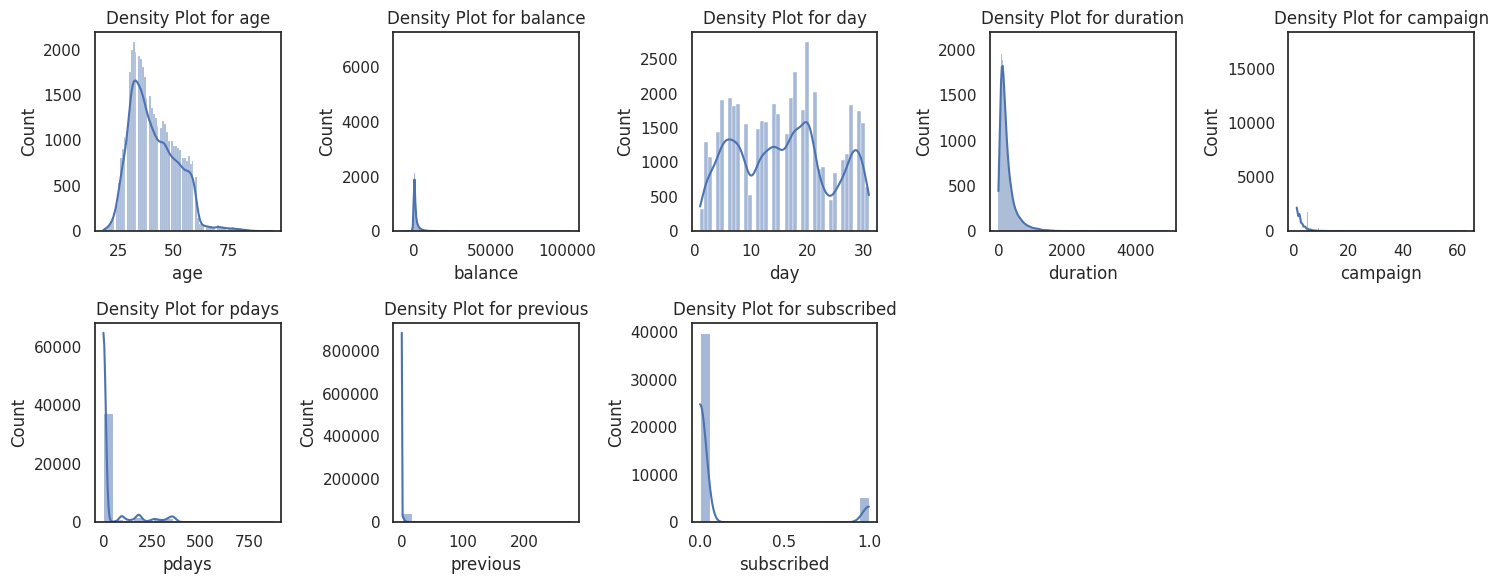

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Select all numeric columns
numeric_columns = data.select_dtypes(include=['number'])

# Calculate the number of rows and columns needed
num_cols = len(numeric_columns.columns)
num_rows = (num_cols - 1) // 5 + 1
num_cols_adjusted = min(num_cols, 5)

# Set the figure size
plt.figure(figsize=(15, 3 * num_rows))

# Loop through each numeric column
for i, column in enumerate(numeric_columns.columns):
    plt.subplot(num_rows, num_cols_adjusted, i + 1)
    sns.histplot(df_train[column], kde=True)
    plt.title(f'Density Plot for {column}')
    plt.xlabel(column)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Exploring Data Analysis

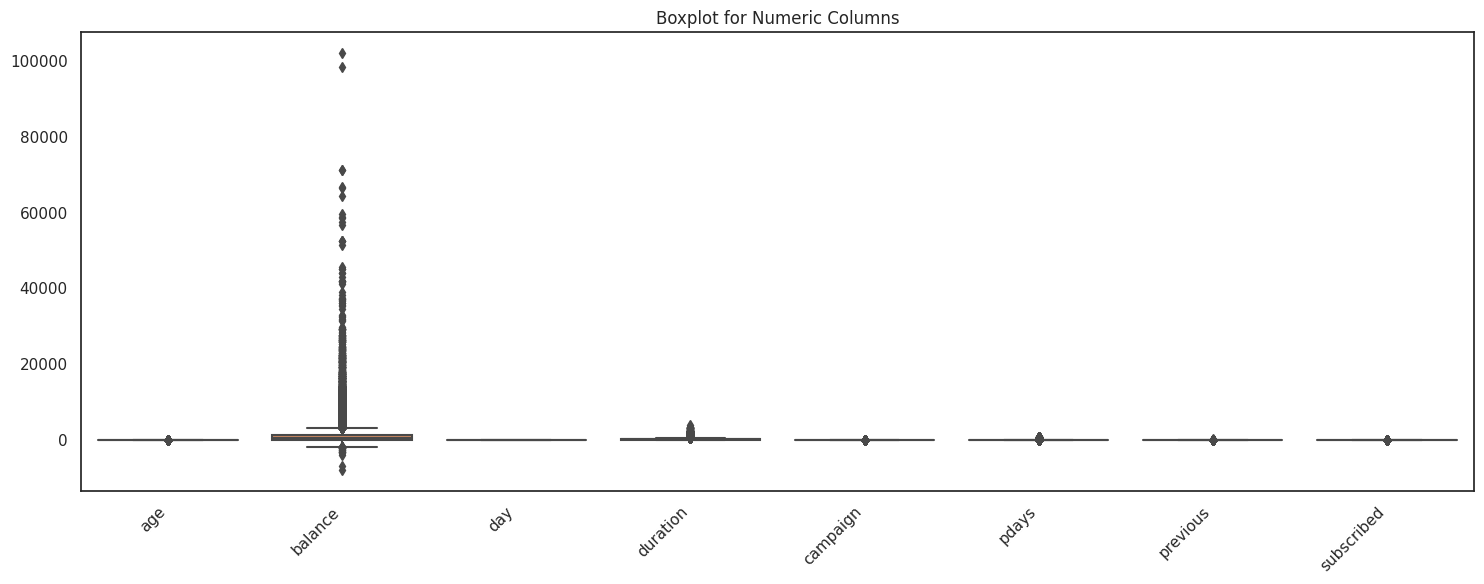

In [ ]:
plt.figure(figsize=(15, 6))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Memutar dan menata label sumbu x
plt.title("Boxplot for Numeric Columns")
plt.tight_layout()  # Memastikan label terlihat dengan baik
plt.show()

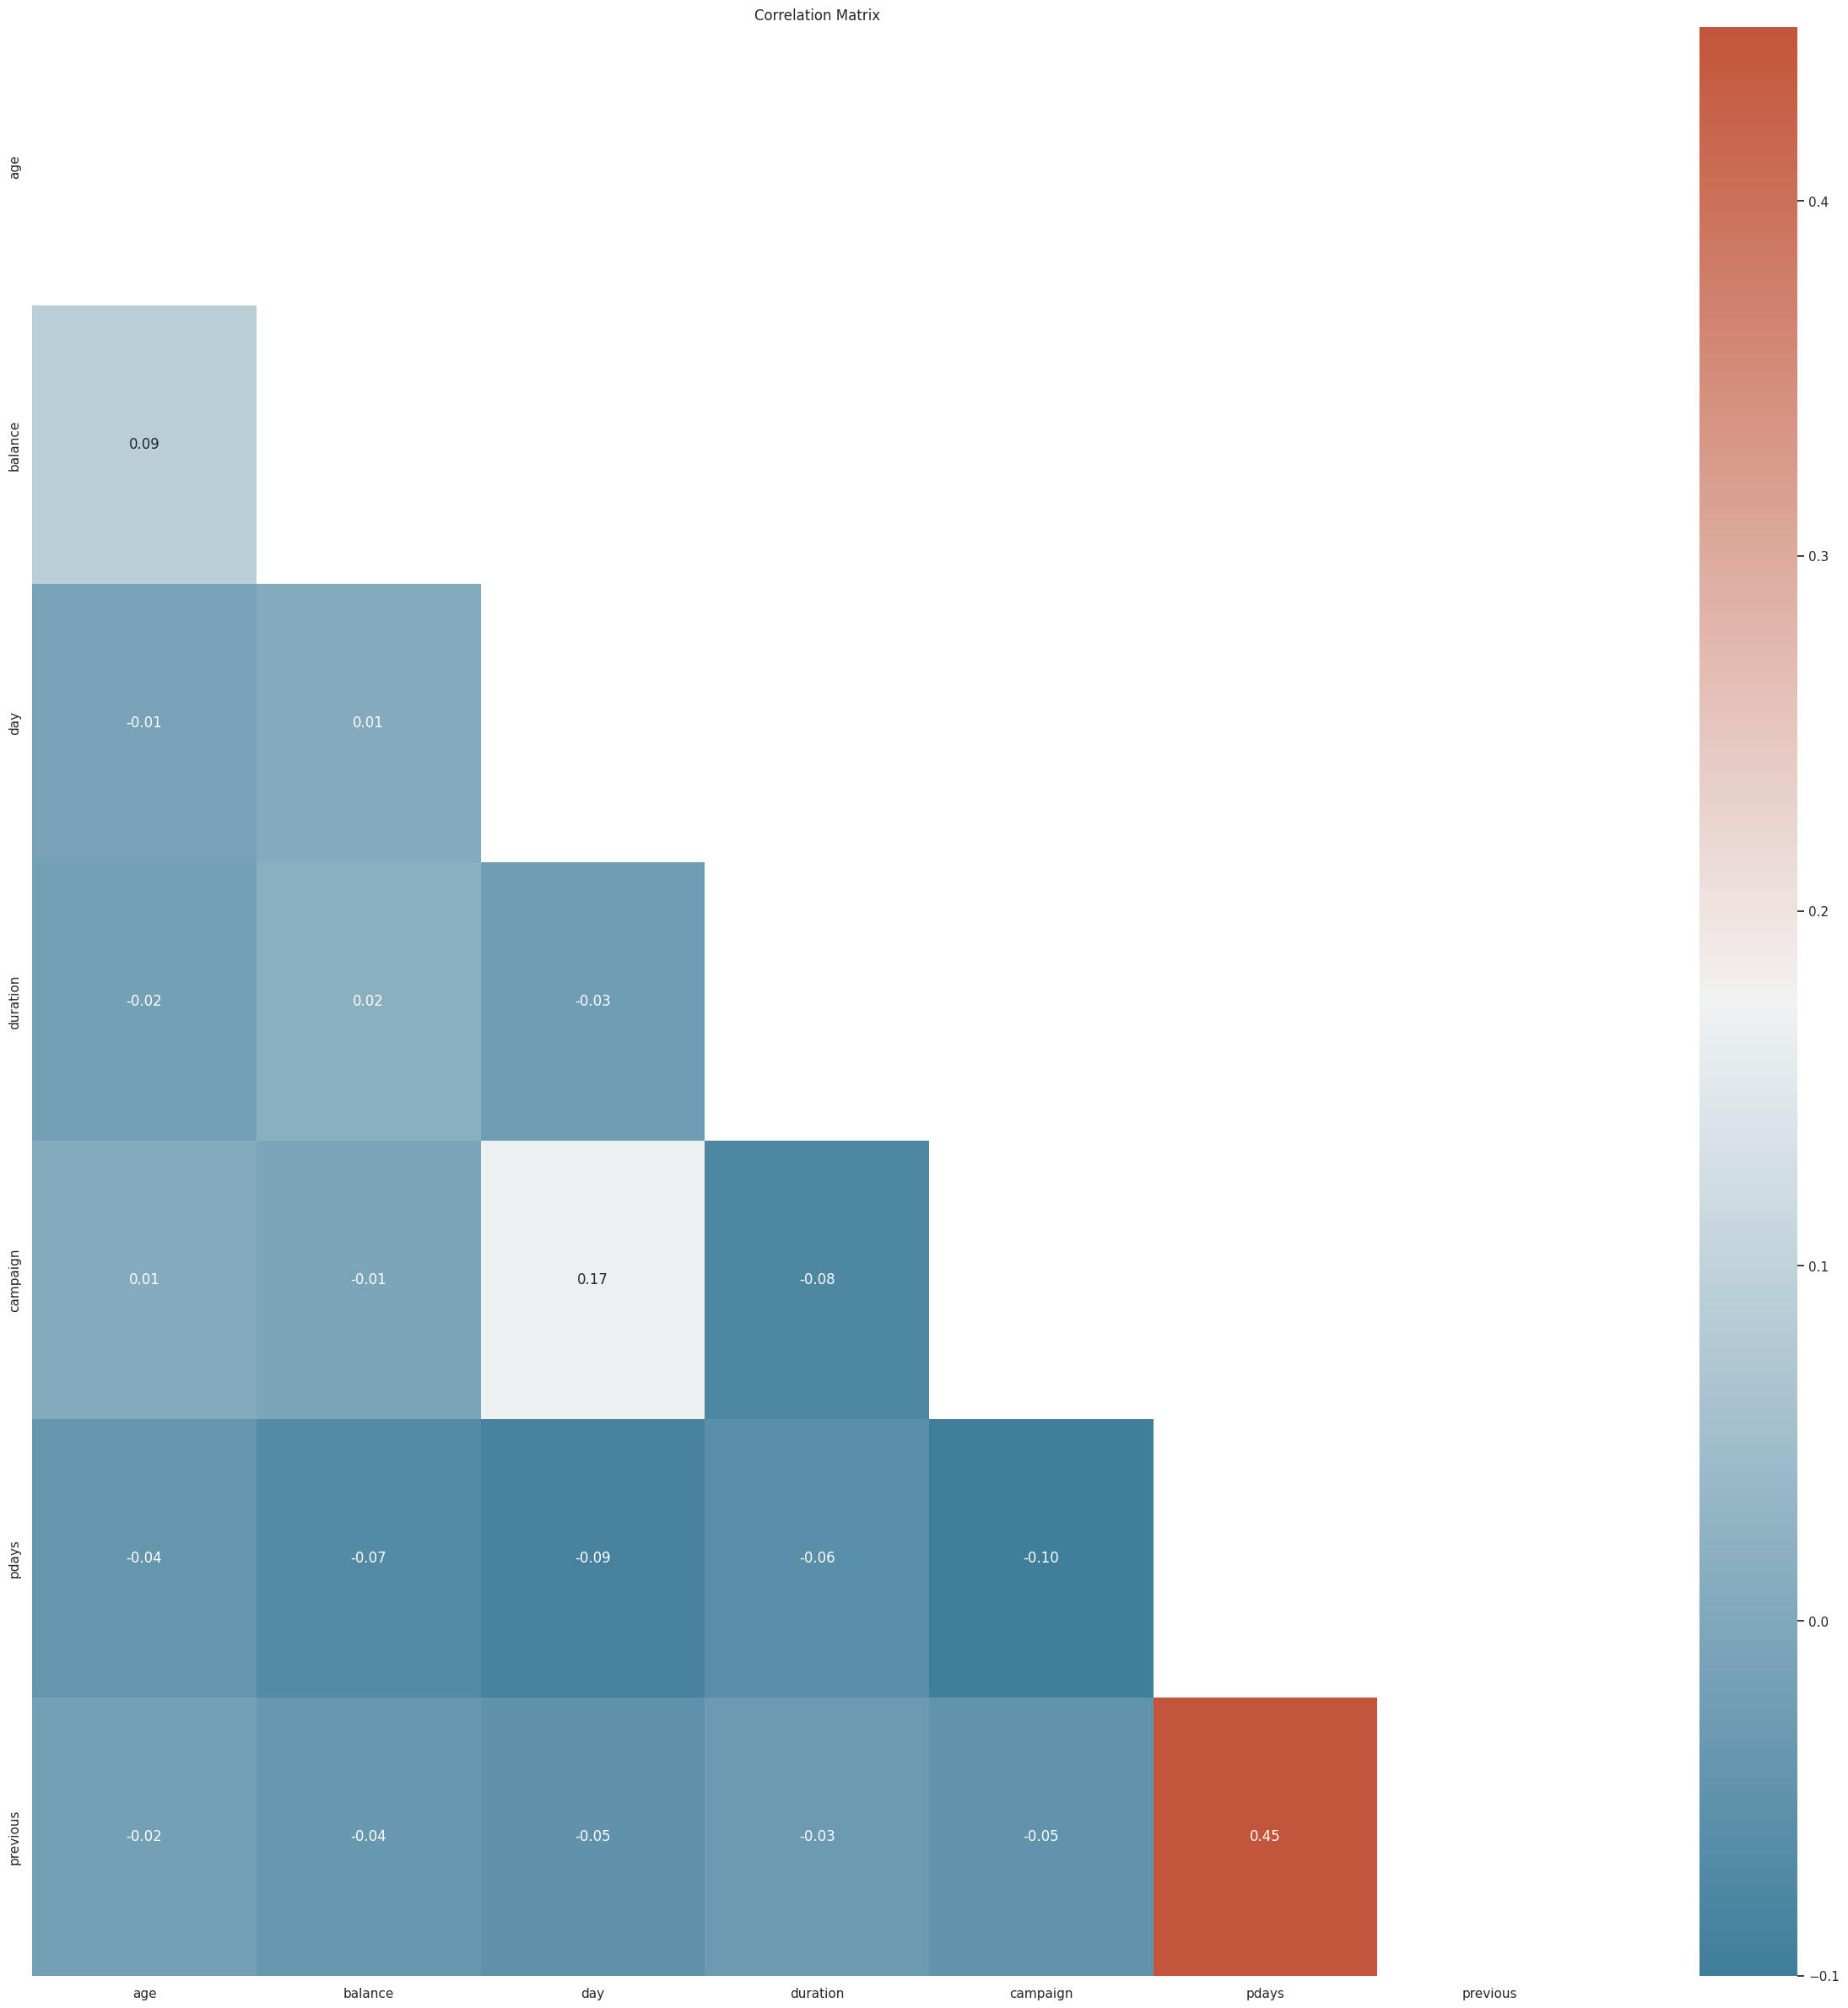

In [ ]:
# Calculate correlation matrix
correlation_matrix = data.corr(numeric_only=True)

# Visualize correlation matrix using a heatmap
plt.figure(figsize=(30, 30))

# Set mask for upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt=".2f", mask=mask)

plt.title("Correlation Matrix")
plt.show()

In [ ]:
data

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,468490,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,0,0,unknown,0
1,164545,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,0,0,unknown,0
2,215296,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,0,0,unknown,0
3,118032,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,0,0,unknown,0
4,206911,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,0,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46110,892476,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,0,0,unknown,0
46111,728452,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,0,0,unknown,0
46112,885844,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,0,0,unknown,0
46113,798285,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,0


## Age

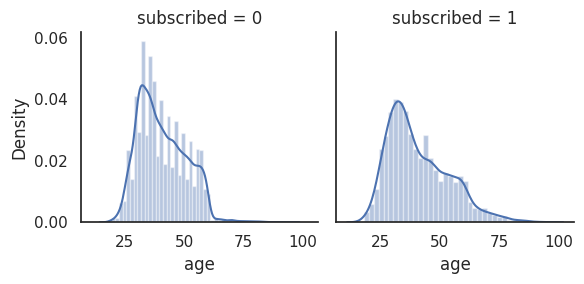

In [13]:
# Explore Age vs Subscribed
g = sns.FacetGrid(data, col='subscribed')
g = g.map(sns.distplot, "age")

In [49]:
import pandas as pd
import numpy as np

# Assuming you have a DataFrame called 'data' with columns 'age' and 'subscribed'
# Define the number of bins for age
num_bins = 10

# Create a new column 'age_bins' by binning the ages
data['age_bins'] = pd.qcut(data['age'], q=num_bins, duplicates='drop')

# Assuming 'data' is your DataFrame and 'age_bins' is a categorical variable
data['age_bins'] = data['age_bins'].cat.reorder_categories(
    data['age_bins'].cat.categories[::-1], ordered=True
)
data = data.sort_values(by='age_bins')

# Calculate the count of each bin for both subscribed and not subscribed groups
age_subscribed = data[data['subscribed'] == 1].groupby('age_bins').size()
age_subscribed_sorted = age_subscribed.sort_index(ascending=True)
age_not_subscribed = data[data['subscribed'] == 0].groupby('age_bins').size()

# Calculate the total count of each bin
total_subscribed = age_subscribed.sum()
total_not_subscribed = age_not_subscribed.sum()

# Calculate the proportion of subscribed and not subscribed within each bin
proportion_subscribed = age_subscribed / total_subscribed
proportion_not_subscribed = age_not_subscribed / total_not_subscribed

# Avoid division by zero and replace NaN values with 0
proportion_subscribed = proportion_subscribed.replace({np.nan: 0})
proportion_not_subscribed = proportion_not_subscribed.replace({np.nan: 0})

# Calculate WoE and Information Value (IV)
woe = np.log(proportion_subscribed / proportion_not_subscribed)
iv = (proportion_subscribed - proportion_not_subscribed) * woe

# Create a DataFrame to store the results
age_woe_table = pd.DataFrame({
    'Bin': age_subscribed_sorted.index,
    'WoE': woe,
    'IV': iv
})

# Change the format of age bins
age_woe_table['Bin'] = age_woe_table['Bin'].astype(str).str.replace(r'\((\d+\.\d+), (\d+\.\d+)\]', r'(\1 - \2]', regex=True)

# Sort the table by WoE values
age_woe_table = age_woe_table.sort_values(by='WoE')

In [50]:
age_woe_table

,Bin,WoE,IV
age_bins,,,
"(39.0, 42.0]",(39.0 - 42.0],-0.319131,0.007890
"(46.0, 51.0]",(46.0 - 51.0],-0.313884,0.009669
"(42.0, 46.0]",(42.0 - 46.0],-0.264924,0.006598
"(51.0, 56.0]",(51.0 - 56.0],-0.193489,0.003240
"(36.0, 39.0]",(36.0 - 39.0],-0.183595,0.003204
"(34.0, 36.0]",(34.0 - 36.0],-0.102430,0.000828
"(32.0, 34.0]",(32.0 - 34.0],-0.068135,0.000392
"(29.0, 32.0]",(29.0 - 32.0],-0.056035,0.000399
"(17.999, 29.0]",(17.999 - 29.0],0.521266,0.038709


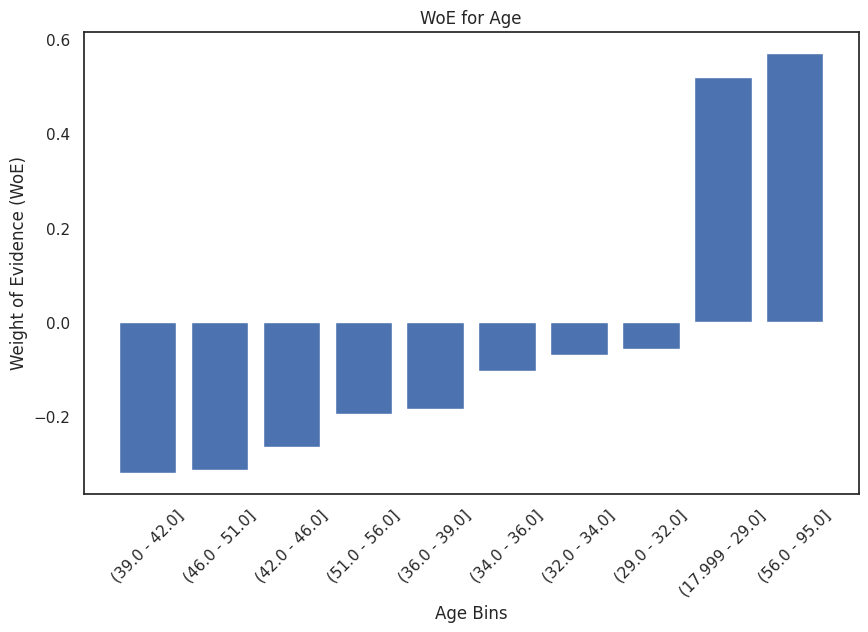

In [51]:
import matplotlib.pyplot as plt

# Create a bar chart to visualize WoE
plt.figure(figsize=(10, 6))
plt.bar(age_woe_table['Bin'].astype(str), age_woe_table['WoE'])
plt.xlabel('Age Bins')
plt.ylabel('Weight of Evidence (WoE)')
plt.title('WoE for Age')
plt.xticks(rotation=45)
plt.show()

## Balance

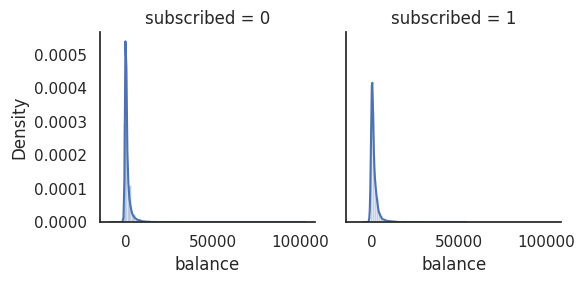

In [32]:
# Explore Age vs Subscribed
g = sns.FacetGrid(data, col='subscribed')
g = g.map(sns.distplot, "balance")

In [67]:
import pandas as pd
import numpy as np

# Assuming you have a DataFrame called 'data' with columns 'balance' and 'subscribed'
# Define the number of bins for balance
num_bins = 10

# Create a new column 'balance_bins' by binning the balances
data['balance_bins'] = pd.qcut(data['balance'], q=num_bins, duplicates='drop')

# Assuming 'data' is your DataFrame and 'balance_bins' is a categorical variable
data['balance_bins'] = data['balance_bins'].cat.reorder_categories(
    data['balance_bins'].cat.categories[::-1], ordered=True
)
data = data.sort_values(by='balance_bins')

# Calculate the count of each bin for both subscribed and not subscribed groups
balance_subscribed = data[data['subscribed'] == 1].groupby('balance_bins').size()
balance_subscribed_sorted = balance_subscribed.sort_index(ascending=True)
balance_not_subscribed = data[data['subscribed'] == 0].groupby('balance_bins').size()

# Calculate the total count of each bin
total_subscribed = balance_subscribed.sum()
total_not_subscribed = balance_not_subscribed.sum()

# Calculate the proportion of subscribed and not subscribed within each bin
proportion_subscribed = balance_subscribed / total_subscribed
proportion_not_subscribed = balance_not_subscribed / total_not_subscribed

# Avoid division by zero and replace NaN values with 0
proportion_subscribed = proportion_subscribed.replace({np.nan: 0})
proportion_not_subscribed = proportion_not_subscribed.replace({np.nan: 0})

# Calculate WoE and Information Value (IV)
woe = np.log(proportion_subscribed / proportion_not_subscribed)
iv = (proportion_subscribed - proportion_not_subscribed) * woe

# Create a DataFrame to store the results
balance_woe_table = pd.DataFrame({
    'Bin': balance_subscribed_sorted.index,
    'WoE': woe,
    'IV': iv
})

# Change the format of balance bins
balance_woe_table['Bin'] = balance_woe_table['Bin'].astype(str).str.replace(r'\(([-.\d]+), ([-.\d]+)\]', r'(\1 - \2]', regex=True)

# Sort the table by WoE values
balance_woe_table = balance_woe_table.sort_values(by='WoE')

In [68]:
balance_woe_table

,Bin,WoE,IV
balance_bins,,,
"(-8019.001, 0.0]",(-8019.001 - 0.0],-0.531967,3.799979e-02
"(0.0, 18.0]",(0.0 - 18.0],-0.369765,4.189823e-03
"(18.0, 119.0]",(18.0 - 119.0],-0.271938,6.613183e-03
"(119.0, 254.0]",(119.0 - 254.0],-0.056899,3.163944e-04
"(254.0, 419.0]",(254.0 - 419.0],0.002249,5.056733e-07
"(419.0, 656.4]",(419.0 - 656.4],0.023559,5.579438e-05
"(656.4, 1036.0]",(656.4 - 1036.0],0.134598,1.911065e-03
"(1036.0, 1695.0]",(1036.0 - 1695.0],0.188037,3.805224e-03
"(3138.0, 102127.0]",(3138.0 - 102127.0],0.238257,6.231266e-03


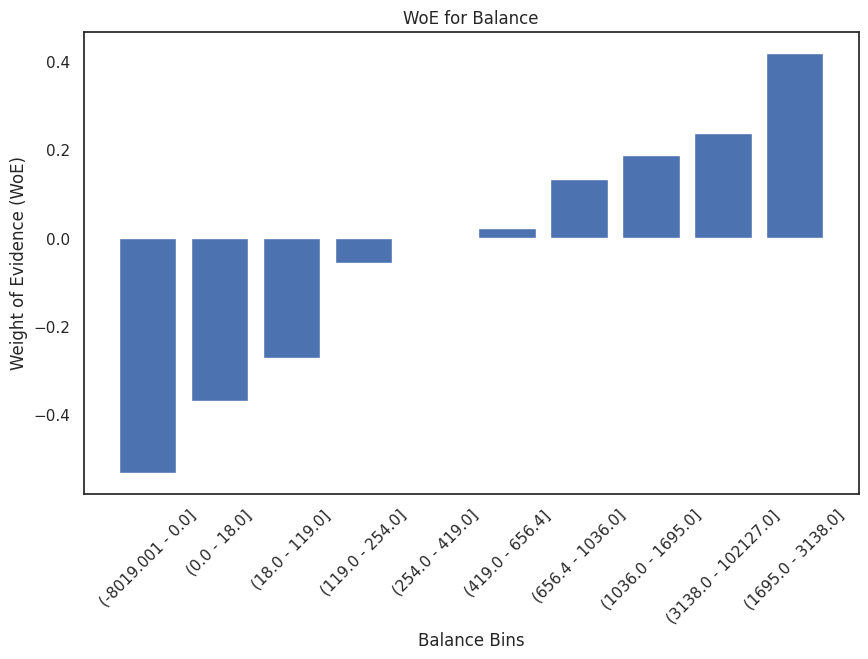

In [69]:
import matplotlib.pyplot as plt

# Create a bar chart to visualize WoE
plt.figure(figsize=(10, 6))
plt.bar(balance_woe_table['Bin'].astype(str), balance_woe_table['WoE'])
plt.xlabel('Balance Bins')
plt.ylabel('Weight of Evidence (WoE)')
plt.title('WoE for Balance')
plt.xticks(rotation=45)
plt.show()

## Duration

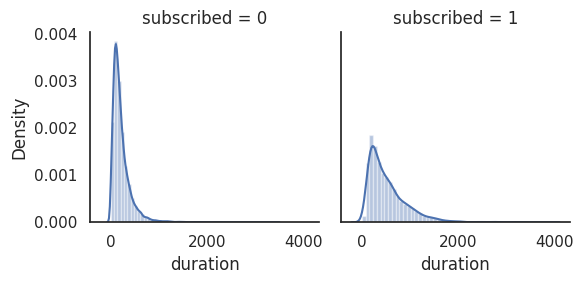

In [87]:
# Explore Day vs Subscribed
g = sns.FacetGrid(data, col='subscribed')
g = g.map(sns.distplot, "duration")

In [90]:
import pandas as pd
import numpy as np

# Assuming you have a DataFrame called 'data' with columns 'day' and 'subscribed'
# Define the number of bins for day
num_bins = 10

# Create a new column 'day_bins' by binning the days
data['duration_bins'] = pd.qcut(data['duration'], q=num_bins, duplicates='drop')

# Assuming 'data' is your DataFrame and 'day_bins' is a categorical variable
data['duration_bins'] = data['duration_bins'].cat.reorder_categories(
    data['duration_bins'].cat.categories[::-1], ordered=True
)
data = data.sort_values(by='duration_bins')

# Calculate the count of each bin for both subscribed and not subscribed groups
duration_subscribed = data[data['subscribed'] == 1].groupby('duration_bins').size()
duration_subscribed_sorted = duration_subscribed.sort_index(ascending=True)
duration_not_subscribed = data[data['subscribed'] == 0].groupby('duration_bins').size()

# Calculate the total count of each bin
total_subscribed = duration_subscribed.sum()
total_not_subscribed = duration_not_subscribed.sum()

# Calculate the proportion of subscribed and not subscribed within each bin
proportion_subscribed = duration_subscribed / total_subscribed
proportion_not_subscribed = duration_not_subscribed / total_not_subscribed

# Avoid division by zero and replace NaN values with 0
proportion_subscribed = proportion_subscribed.replace({np.nan: 0})
proportion_not_subscribed = proportion_not_subscribed.replace({np.nan: 0})

# Calculate WoE and Information Value (IV)
woe = np.log(proportion_subscribed / proportion_not_subscribed)
iv = (proportion_subscribed - proportion_not_subscribed) * woe

# Create a DataFrame to store the results
duration_woe_table = pd.DataFrame({
    'Bin': duration_subscribed_sorted.index,
    'WoE': woe,
    'IV': iv
})

# Change the format of day bins
duration_woe_table['Bin'] = duration_woe_table['Bin'].astype(str).str.replace(r'\(([-.\d]+), ([-.\d]+)\]', r'(\1 - \2]', regex=True)

# Sort the table by WoE values
duration_woe_table = duration_woe_table.sort_values(by='WoE')

In [91]:
duration_woe_table

,Bin,WoE,IV
duration_bins,,,
"(-0.001, 58.0]",(-0.001 - 58.0],-4.114764,0.455633
"(58.0, 89.0]",(58.0 - 89.0],-2.353268,0.242514
"(89.0, 116.0]",(89.0 - 116.0],-1.357791,0.106507
"(116.0, 145.0]",(116.0 - 145.0],-1.039927,0.072259
"(145.0, 178.0]",(145.0 - 178.0],-0.556171,0.025016
"(178.0, 219.0]",(178.0 - 219.0],-0.325220,0.009165
"(219.0, 273.0]",(219.0 - 273.0],0.062000,0.000393
"(273.0, 360.0]",(273.0 - 360.0],0.140896,0.002118
"(360.0, 525.0]",(360.0 - 525.0],0.674693,0.058491


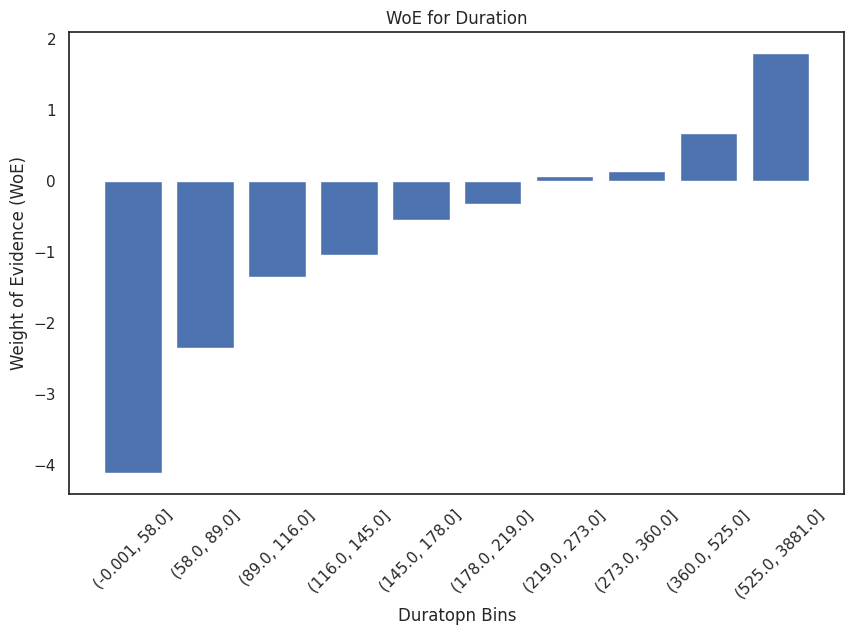

In [92]:
import matplotlib.pyplot as plt

# Create a bar chart to visualize WoE
plt.figure(figsize=(10, 6))
plt.bar(duration_woe_table.index.astype(str), duration_woe_table['WoE'])  # Using the index (day_bins) as x-axis
plt.xlabel('Duratopn Bins')
plt.ylabel('Weight of Evidence (WoE)')
plt.title('WoE for Duration')
plt.xticks(rotation=45)
plt.show()

In [93]:
import pandas as pd
import numpy as np

# Define the number of bins
num_bins = 10

# Define the numerical columns
numerical_columns = ['day', 'campaign', 'pdays', 'previous']

# Create a DataFrame 'woe_iv_results' to store results
woe_iv_results = pd.DataFrame()

for column in numerical_columns:
    # Create bins
    data[column+'_bins'] = pd.qcut(data[column], q=num_bins, duplicates='drop')

    # Calculate WoE and IV
    subscribed = data[data['subscribed'] == 1].groupby(column+'_bins').size()
    not_subscribed = data[data['subscribed'] == 0].groupby(column+'_bins').size()

    total_subscribed = subscribed.sum()
    total_not_subscribed = not_subscribed.sum()

    proportion_subscribed = subscribed / total_subscribed
    proportion_not_subscribed = not_subscribed / total_not_subscribed

    woe = np.log(proportion_subscribed / proportion_not_subscribed)
    iv = (proportion_subscribed - proportion_not_subscribed) * woe

    # Create a DataFrame to store the results for this column
    woe_iv_column = pd.DataFrame({
        'Bin': subscribed.index,
        'WoE': woe,
        'IV': iv
    })

    woe_iv_column['Variable'] = column  # Add the variable name

    # Append the results to the main DataFrame
    woe_iv_results = pd.concat([woe_iv_results, woe_iv_column], ignore_index=True)

# Change the format of bins
woe_iv_results['Bin'] = woe_iv_results['Bin'].astype(str).str.replace(r'\(([-.\d]+), ([-.\d]+)\]', r'(\1 - \2]', regex=True)

# Sort the table by WoE values
woe_iv_results = woe_iv_results.sort_values(by='WoE')

In [94]:
woe_iv_results

,Bin,WoE,IV,Variable
14,(5.0 - 63.0],-0.715533,0.036969,campaign
6,(18.0 - 20.0],-0.546228,0.023999,day
13,(4.0 - 5.0],-0.469539,0.007184,campaign
1,(5.0 - 7.0],-0.329362,0.007951,day
12,(3.0 - 4.0],-0.206506,0.003096,campaign
5,(16.0 - 18.0],-0.170303,0.002512,day
17,(-0.001 - 1.0],-0.121421,0.012704,previous
11,(2.0 - 3.0],-0.076010,0.000688,campaign
15,(-0.001 - 170.0],-0.055021,0.002667,pdays
8,(24.0 - 28.0],-0.050552,0.000270,day


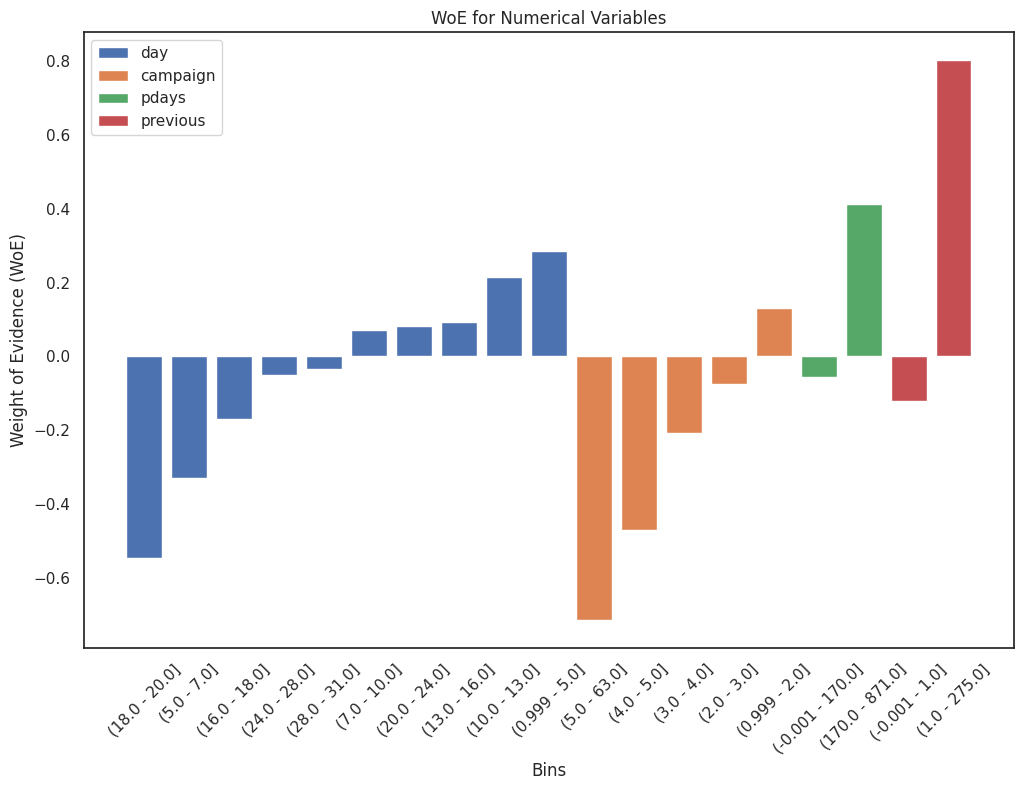

In [95]:
import matplotlib.pyplot as plt

# Create a bar chart to visualize WoE for numerical variables
plt.figure(figsize=(12, 8))

for column in numerical_columns:
    # Filter WoE results for the current variable
    woe_iv_column = woe_iv_results[woe_iv_results['Variable'] == column]

    plt.bar(woe_iv_column['Bin'], woe_iv_column['WoE'], label=column)

plt.xlabel('Bins')
plt.ylabel('Weight of Evidence (WoE)')
plt.title('WoE for Numerical Variables')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [85]:
# Define the categorical columns
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Create a DataFrame 'woe_iv_results' to store results (if not already created in the previous script)
if 'woe_iv_results' not in locals():
    woe_iv_results = pd.DataFrame()

for column in categorical_columns:
    # Calculate WoE and IV
    subscribed = data[data['subscribed'] == 1].groupby(column).size()
    not_subscribed = data[data['subscribed'] == 0].groupby(column).size()

    total_subscribed = subscribed.sum()
    total_not_subscribed = not_subscribed.sum()

    proportion_subscribed = subscribed / total_subscribed
    proportion_not_subscribed = not_subscribed / total_not_subscribed

    woe = np.log(proportion_subscribed / proportion_not_subscribed)
    iv = (proportion_subscribed - proportion_not_subscribed) * woe

    # Create a DataFrame to store the results for this column
    woe_iv_column = pd.DataFrame({
        'Bin': subscribed.index,  # Assuming categorical columns don't need binning
        'WoE': woe,
        'IV': iv
    })

    woe_iv_column['Variable'] = column  # Add the variable name

    # Append the results to the main DataFrame
    woe_iv_results = pd.concat([woe_iv_results, woe_iv_column], ignore_index=True)

# Sort the table by WoE values
woe_iv_results = woe_iv_results.sort_values(by='WoE')

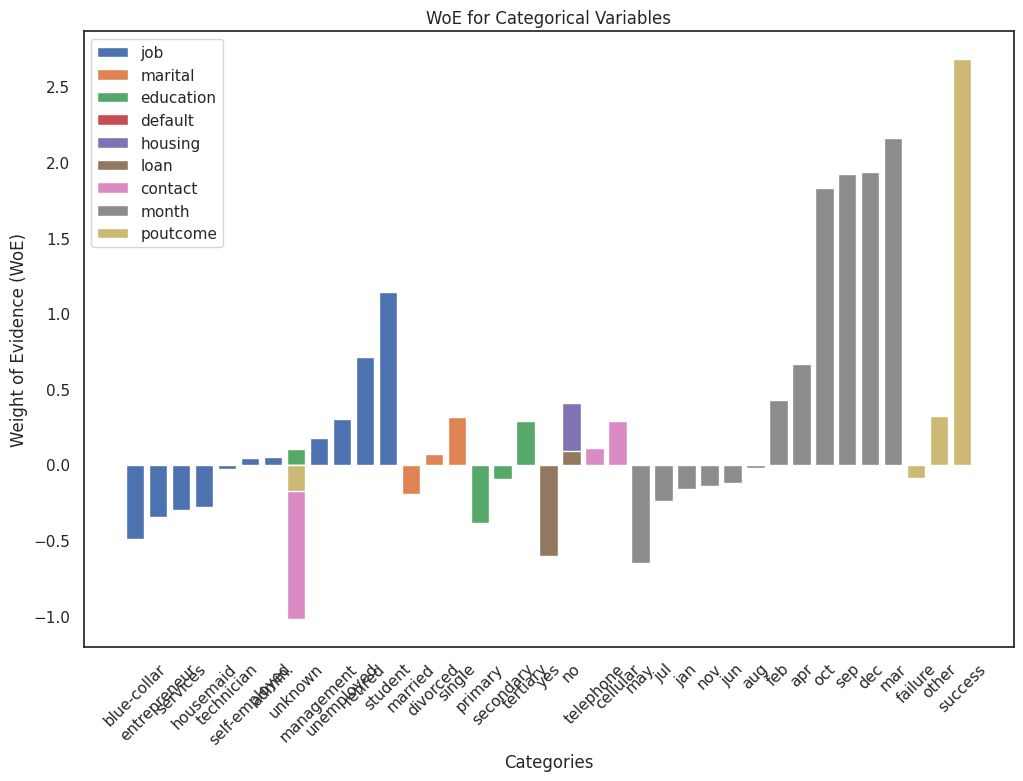

In [86]:
# Create a bar chart to visualize WoE for categorical variables
plt.figure(figsize=(12, 8))

for column in categorical_columns:
    # Filter WoE results for the current variable
    woe_iv_column = woe_iv_results[woe_iv_results['Variable'] == column]

    plt.bar(woe_iv_column['Bin'], woe_iv_column['WoE'], label=column)

plt.xlabel('Categories')
plt.ylabel('Weight of Evidence (WoE)')
plt.title('WoE for Categorical Variables')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Feature Engineering

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# List of categorical columns to encode
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Encode each categorical column and drop the original
for col in categorical_columns:
    data[col + '_encoded'] = label_encoder.fit_transform(data[col])
    data.drop(col, axis=1, inplace=True)

In [ ]:
data

,ID,age,balance,day,duration,campaign,pdays,previous,subscribed,job_encoded,marital_encoded,education_encoded,default_encoded,housing_encoded,loan_encoded,contact_encoded,month_encoded,poutcome_encoded
0,468490,58,2143,5,261,1,0,0,0,4,1,2,0,1,0,2,8,3
1,164545,44,29,5,151,1,0,0,0,9,2,1,0,1,0,2,8,3
2,215296,33,2,5,76,1,0,0,0,2,1,1,0,1,1,2,8,3
3,118032,47,1506,5,92,1,0,0,0,1,1,3,0,1,0,2,8,3
4,206911,33,1,5,198,1,0,0,0,11,2,3,0,0,0,2,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46110,892476,33,-333,30,329,5,0,0,0,7,1,1,0,1,0,0,5,3
46111,728452,57,-3313,9,153,1,0,0,0,6,1,2,1,1,1,2,8,3
46112,885844,57,295,19,151,11,0,0,0,9,1,1,0,0,0,0,1,3
46113,798285,28,1137,6,129,4,211,3,0,1,1,1,0,0,0,0,3,1


# Model Machine Learning Evaluation

In [ ]:
df_train = data[:train_len]
df_test = data[train_len:]

In [ ]:
df_test

,ID,age,balance,day,duration,campaign,pdays,previous,subscribed,job_encoded,marital_encoded,education_encoded,default_encoded,housing_encoded,loan_encoded,contact_encoded,month_encoded,poutcome_encoded
45211,789584,58,35,29,336,7,0,0,0,5,1,1,0,0,0,0,5,3
45212,751200,68,19317,4,249,1,0,0,1,5,1,1,0,1,0,0,1,3
45213,748178,43,50,28,63,1,0,0,0,9,1,1,0,0,0,2,8,3
45214,858603,44,-674,5,257,1,0,0,0,1,1,1,0,1,0,2,8,3
45215,823392,49,3726,5,875,2,0,0,1,9,1,2,0,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46110,892476,33,-333,30,329,5,0,0,0,7,1,1,0,1,0,0,5,3
46111,728452,57,-3313,9,153,1,0,0,0,6,1,2,1,1,1,2,8,3
46112,885844,57,295,19,151,11,0,0,0,9,1,1,0,0,0,0,1,3
46113,798285,28,1137,6,129,4,211,3,0,1,1,1,0,0,0,0,3,1


In [ ]:
## Separate train features and label
df_train["subscribed"] = df_train["subscribed"].astype(int)
y_train = df_train["subscribed"]
X_train = df_train.drop(labels = ["subscribed", "ID"],axis = 1)

In [ ]:
# Create and train Random Forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42, max_features='sqrt')
clf = clf.fit(X_train, y_train)

In [ ]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

In [ ]:
import pandas as pd
from prettytable import PrettyTable

# Assuming 'features' DataFrame is already defined
# 'features' should be sorted by importance values

# Sort features by importance in descending order
features_sorted = features.sort_values(by='importance', ascending=False)

# Create a PrettyTable object
table = PrettyTable()

# Define the column names and alignment
table.field_names = ["Feature", "Importance"]

# Add data to the table
for index, row in features_sorted.iterrows():
    table.add_row([index, row['importance']])

# Print the table
print(table)

+-------------------+-----------------------+
|      Feature      |       Importance      |
+-------------------+-----------------------+
|      duration     |   0.2915313814750117  |
|      balance      |  0.11438444322217702  |
|        age        |  0.10764257016792764  |
|   month_encoded   |  0.09263978906733741  |
|        day        |  0.09215026258860544  |
|    job_encoded    |  0.04999936874297545  |
|       pdays       |  0.043963341075198406 |
|  poutcome_encoded |  0.04186915854387839  |
|      campaign     |  0.03995304767919952  |
| education_encoded |  0.02870330628792367  |
|  housing_encoded  |  0.024085289684456217 |
|  marital_encoded  |  0.02285485985808012  |
|  contact_encoded  |  0.021037546528882504 |
|      previous     |  0.016647904808136334 |
|    loan_encoded   |  0.01061128169739677  |
|  default_encoded  | 0.0019264485728134409 |
+-------------------+-----------------------+


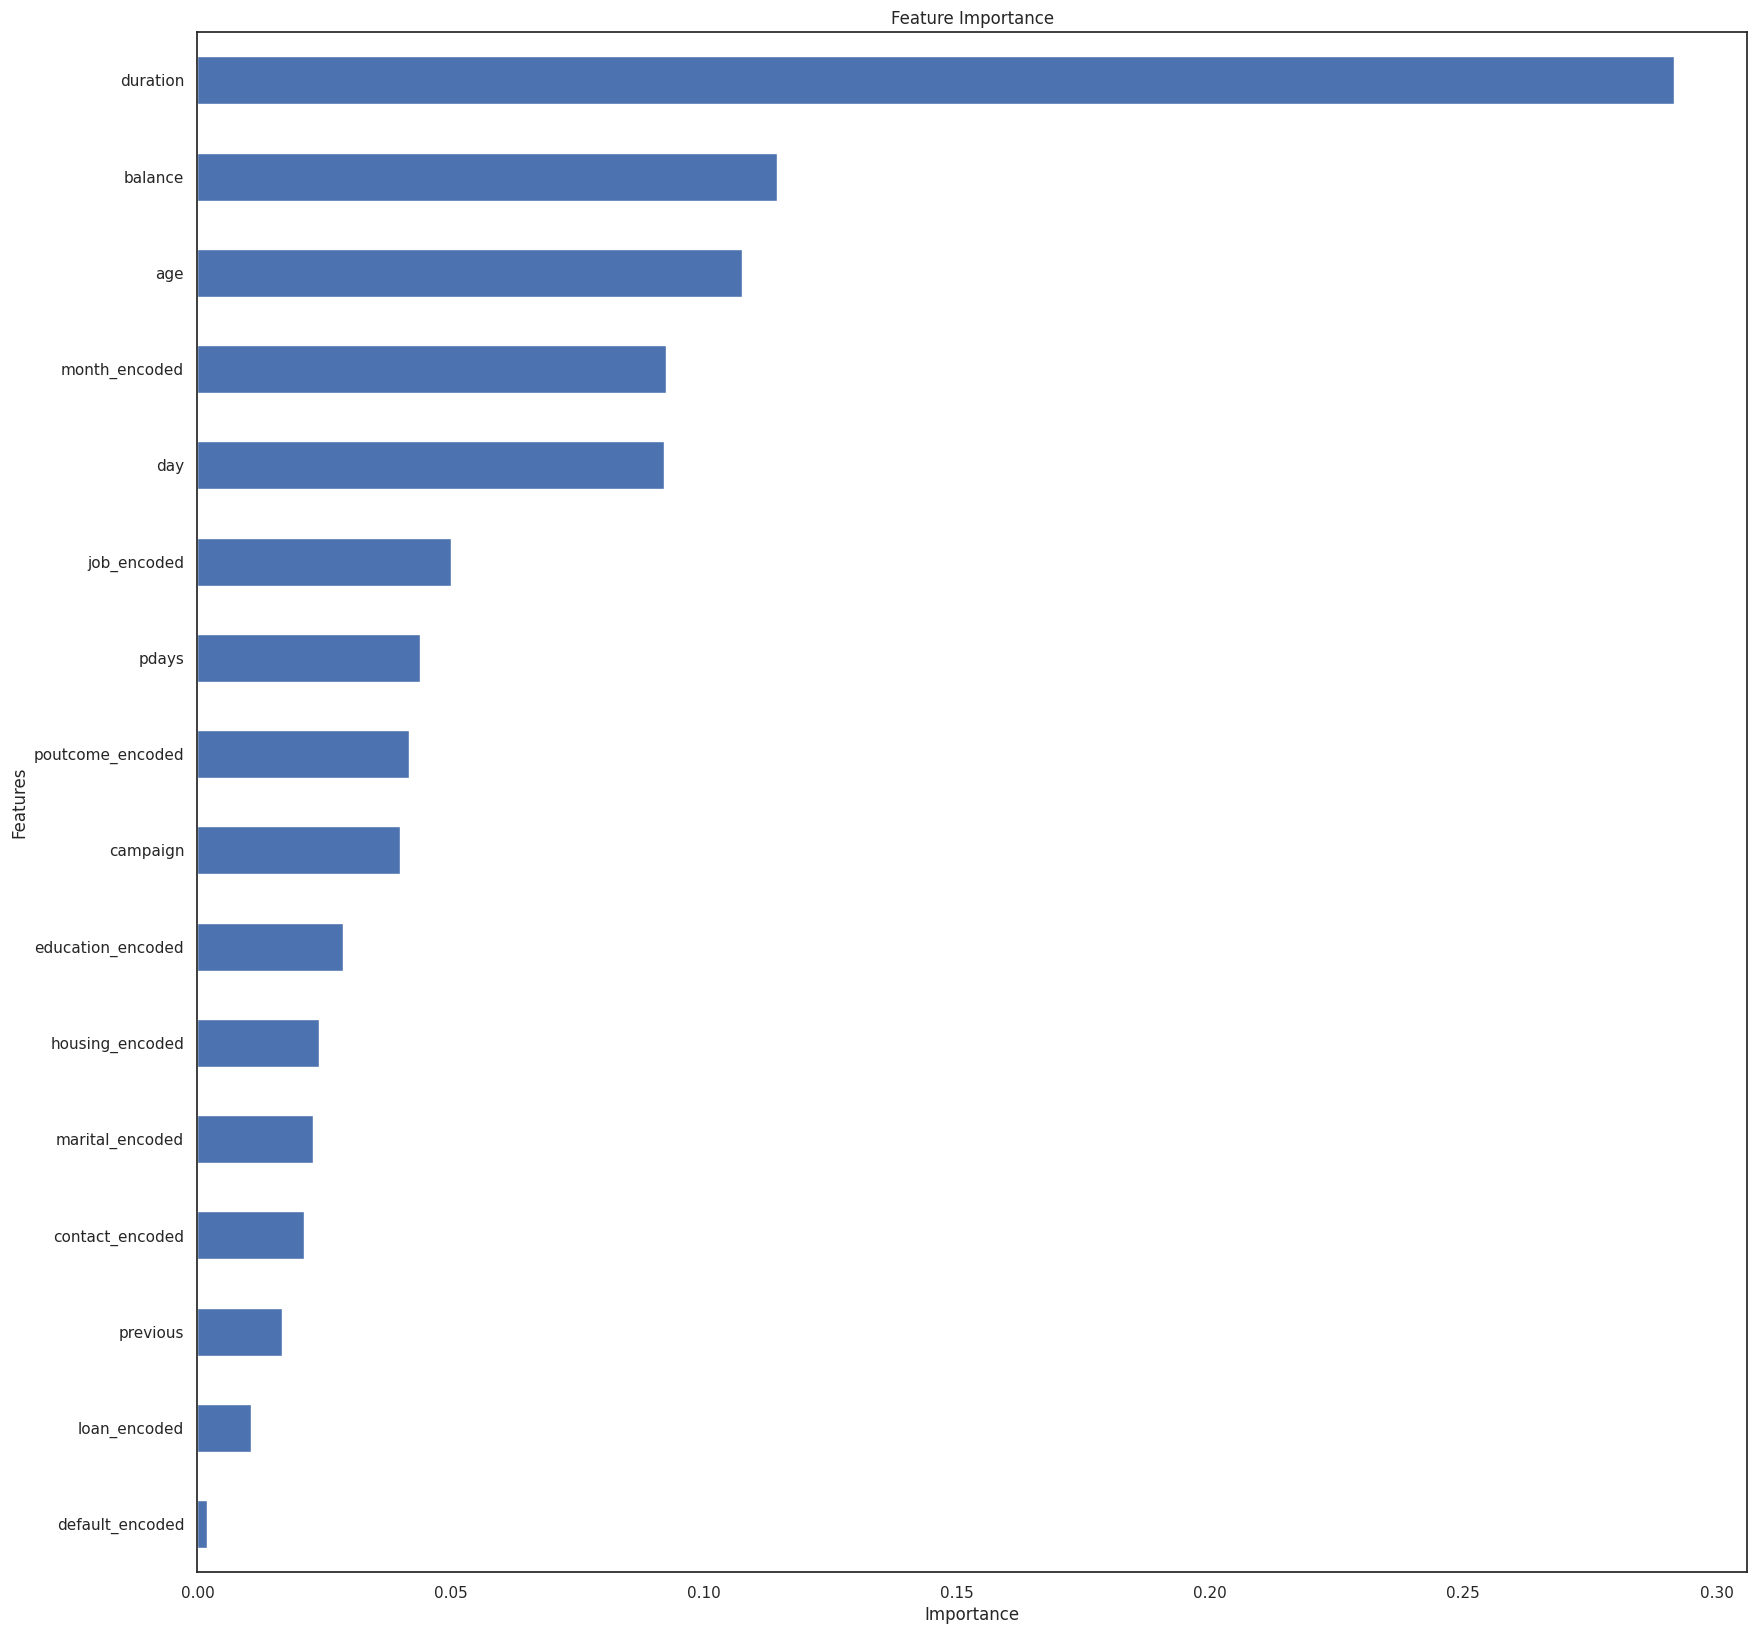

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'features' DataFrame is already defined

# Create the horizontal bar plot
features['importance'].plot(kind='barh', figsize=(20, 20))

# Set labels and title
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')

plt.show()

Do the cross testation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import copy

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming df_test is a DataFrame with the same features as df_train (excluding "subscribed" and "ID")
X_test = df_test.drop(labels=["subscribed", "ID"], axis=1)
y_test = df_test["subscribed"]

In [ ]:
# Load your data (X_train, y_train, X_test, y_test) here

# Create a list of model parameters
def create_model_param():
    model_params = {
        'RandomForest': {
            'n_estimators': [10, 50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        },
        # Define parameters for other models as needed
    }
    return model_params

# Create a list of model objects
def create_model_object():
    models = [
        {
            'model_name': 'RandomForest',
            'model_object': RandomForestClassifier(n_estimators=100, random_state=123)
        },
        # Add more models as needed
    ]
    return models

def train_model(X_train, y_train, X_test, y_test, return_file=True):
    list_of_param = create_model_param()
    list_of_model = create_model_object()

    list_of_tuned_model = {}

    for base_model in list_of_model:
        model_name = base_model['model_name']
        model_obj = copy.deepcopy(base_model['model_object'])
        model_param = list_of_param[model_name]

        print('Training model:', model_name)

        model = RandomizedSearchCV(estimator=model_obj,
                                   param_distributions=model_param,
                                   n_iter=5,
                                   cv=5,
                                   random_state=123,
                                   n_jobs=1,
                                   verbose=10,
                                   scoring='roc_auc')

        model.fit(X_train, y_train)

        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]

        train_score = roc_auc_score(y_train, y_pred_proba_train)
        test_score = roc_auc_score(y_test, y_pred_proba_test)

        list_of_tuned_model[model_name] = {
            'model': model,
            'train_auc': train_score,
            'test_auc': test_score,
            'best_params': model.best_params_
        }

        print("Done training")
        print("")

    if return_file:
        return list_of_param, list_of_model, list_of_tuned_model

In [ ]:
# Call the function with your data
list_of_param, list_of_model, list_of_tuned_model = train_model(X_train, y_train, X_test, y_test)

Training model: RandomForest
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50
[CV 1/5; 1/5] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.906 total time=   3.1s
[CV 2/5; 1/5] START max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50
[CV 2/5; 1/5] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.764 total time=   2.4s
[CV 3/5; 1/5] START max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50
[CV 3/5; 1/5] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.753 total time=   2.3s
[CV 4/5; 1/5] START max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50
[CV 4/5; 1/5] END max_depth=None, 

In [ ]:
list_of_tuned_model

{'RandomForest': {'model': RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
                     n_iter=5, n_jobs=1,
                     param_distributions={'max_depth': [None, 10, 20, 30],
                                          'max_features': ['auto', 'sqrt',
                                                           'log2'],
                                          'min_samples_leaf': [1, 2, 4],
                                          'min_samples_split': [2, 5, 10],
                                          'n_estimators': [10, 50, 100, 200]},
                     random_state=123, scoring='roc_auc', verbose=10),
  'train_auc': 0.9991596210670756,
  'test_auc': 0.9992478699924786,
  'best_params': {'n_estimators': 200,
   'min_samples_split': 5,
   'min_samples_leaf': 1,
   'max_features': 'log2',
   'max_depth': 20}}}

In [ ]:
import joblib

def get_best_model(list_of_tuned_model, return_file=True):
    """Function to get the best model"""

    # Get the best model
    best_model_name = None
    best_model = None
    best_performance = -99999
    best_model_param = None

    for model_name, model_data in list_of_tuned_model.items():
        test_auc = model_data['test_auc']  # Change 'test_auc' to 'test_auc' if that's what you're using
        if test_auc > best_performance:
            best_model_name = model_name
            best_model = model_data['model']
            best_performance = test_auc
            best_model_param = model_data['best_params']

    # Optionally save the best model to a file using joblib
    if return_file:
        save_best_model(best_model, "best_model.joblib")

    # Print
    print('=============================================')
    print('Best model        :', best_model_name)
    print('Metric score      :', best_performance)
    print('Best model params :', best_model_param)
    print('=============================================')

    if return_file:
        return best_model

# Function to save the best model to a file using joblib
def save_best_model(model, filename):
    joblib.dump(model, filename)

In [ ]:
# Example usage:
best_model = get_best_model(list_of_tuned_model)

Best model        : RandomForest
Metric score      : 0.9992478699924786
Best model params : {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}


In [ ]:
best_model

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
                   n_iter=5, n_jobs=1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200]},
                   random_state=123, scoring='roc_auc', verbose=10)

In [ ]:
best_model.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50
[CV 1/5; 1/5] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.906 total time=   2.5s
[CV 2/5; 1/5] START max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50
[CV 2/5; 1/5] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.764 total time=   2.4s
[CV 3/5; 1/5] START max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50
[CV 3/5; 1/5] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.753 total time=   2.9s
[CV 4/5; 1/5] START max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50
[CV 4/5; 1/5] END max_depth=None, max_features=auto, min_sample

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
                   n_iter=5, n_jobs=1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200]},
                   random_state=123, scoring='roc_auc', verbose=10)

In [ ]:
# Save the model using joblib
import joblib
joblib.dump(best_model, 'best_model.joblib')

['best_model.joblib']

In [ ]:
# Load the model
model = joblib.load('best_model.joblib')

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

Accuracy: 0.9811946902654868
Precision: 1.0
Recall: 0.8316831683168316
F1-score: 0.9081081081081082


In [ ]:
from sklearn.metrics import roc_auc_score
# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC-AUC: {roc_auc}')

# Calculate Gini coefficient
gini_coefficient = 2 * roc_auc - 1
print(f'Gini Coefficient: {gini_coefficient}')

ROC-AUC: 0.9158415841584158
Gini Coefficient: 0.8316831683168315


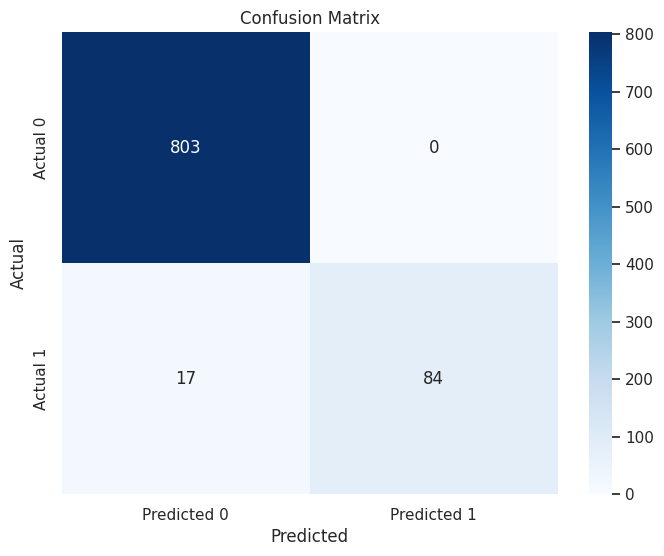

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Building Credit Scoring Model

In [ ]:
results_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/df_test.csv')

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Change datatype of 'ID' column in df_test
results_df[['ID','subscribed']] = results_df[['ID','subscribed']].astype(str)

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# List of categorical columns to encode
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Encode each categorical column and drop the original
for col in categorical_columns:
    results_df[col + '_encoded'] = label_encoder.fit_transform(results_df[col])
    results_df.drop(col, axis=1, inplace=True)

In [ ]:
df_test

,ID,age,balance,day,duration,campaign,pdays,previous,subscribed,job_encoded,marital_encoded,education_encoded,default_encoded,housing_encoded,loan_encoded,contact_encoded,month_encoded,poutcome_encoded
45211,789584,58,35,29,336,7,0,0,0,5,1,1,0,0,0,0,5,3
45212,751200,68,19317,4,249,1,0,0,1,5,1,1,0,1,0,0,1,3
45213,748178,43,50,28,63,1,0,0,0,9,1,1,0,0,0,2,8,3
45214,858603,44,-674,5,257,1,0,0,0,1,1,1,0,1,0,2,8,3
45215,823392,49,3726,5,875,2,0,0,1,9,1,2,0,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46110,892476,33,-333,30,329,5,0,0,0,7,1,1,0,1,0,0,5,3
46111,728452,57,-3313,9,153,1,0,0,0,6,1,2,1,1,1,2,8,3
46112,885844,57,295,19,151,11,0,0,0,9,1,1,0,0,0,0,1,3
46113,798285,28,1137,6,129,4,211,3,0,1,1,1,0,0,0,0,3,1


In [ ]:
# Use the trained model to predict probabilities
df_test = df_test.drop(['ID', 'subscribed'], axis=1)

DefaultProba = model.predict_proba(df_test)
DefaultProba = DefaultProba[:, 1]  # Extract probabilities for the positive class

In [ ]:
results_df

,ID,age,balance,day,duration,campaign,pdays,previous,subscribed,job_encoded,marital_encoded,education_encoded,default_encoded,housing_encoded,loan_encoded,contact_encoded,month_encoded,poutcome_encoded
0,798059,30,1787,19,79,1,0,0,0,10,1,0,0,0,0,0,10,3
1,746932,33,4789,11,220,1,339,4,0,7,1,1,0,1,1,0,8,0
2,824847,35,1350,16,185,1,330,1,0,4,2,2,0,1,0,0,0,0
3,713458,30,1476,3,199,4,0,0,0,4,1,2,0,1,1,2,6,3
4,808161,59,0,5,226,1,0,0,0,1,1,1,0,1,0,2,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,892476,33,-333,30,329,5,0,0,0,7,1,1,0,1,0,0,5,3
4517,728452,57,-3313,9,153,1,0,0,0,6,1,2,1,1,1,2,8,3
4518,885844,57,295,19,151,11,0,0,0,9,1,1,0,0,0,0,1,3
4519,798285,28,1137,6,129,4,211,3,0,1,1,1,0,0,0,0,3,1


In [ ]:
results_df = results_df.drop(['age', 'balance', 'day', 'duration', 'campaign', 'pdays',
       'previous', 'job_encoded', 'marital_encoded',
       'education_encoded', 'default_encoded', 'housing_encoded',
       'loan_encoded', 'contact_encoded', 'month_encoded', 'poutcome_encoded'], axis=1)

In [ ]:
# Create a new DataFrame with the probabilities and correct index
proba_df = pd.DataFrame(DefaultProba, columns=['Probability'], index=df_test.index)

# Add a placeholder column for 'subscribed' and set all values to 0
df_test['subscribed'] = 0

# Merge the DataFrames using the index
results_df = df_test.merge(proba_df, left_index=True, right_index=True, how='left')

# Get the indices where the probability is above a certain threshold (e.g., 0.5)
threshold = 0.5
positive_indices = proba_df[proba_df['Probability'] > threshold].index

# Set 'subscribed' to 1 for these positive predictions
results_df.loc[positive_indices, 'subscribed'] = 1

# Assuming 'ID' is present in df_test
results_df['ID'] = df_test.index  # Add 'ID' column

# Reference 'ID', 'subscribed', and 'Probability' from results_df
results_df = results_df[['ID', 'subscribed', 'Probability']]

In [ ]:
results_df

,ID,subscribed,Probability
45211,45211,0,0.032534
45212,45212,1,0.717939
45213,45213,0,0.005000
45214,45214,0,0.000000
45215,45215,1,0.793515
...,...,...,...
46110,46110,0,0.009649
46111,46111,0,0.005833
46112,46112,0,0.001769
46113,46113,0,0.032272


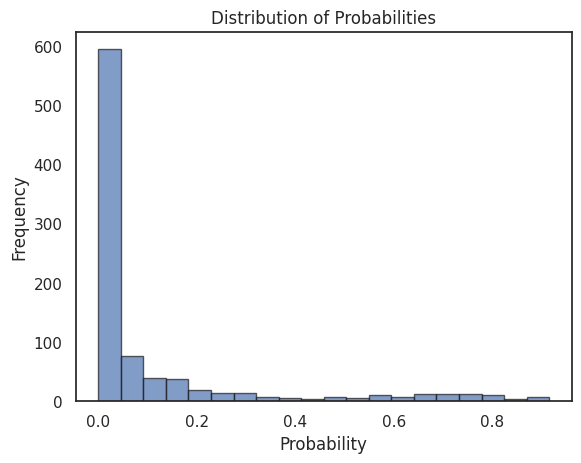

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'results_df' contains the probabilities
# You can access the probabilities column with results_df['Probability']

# Create a histogram to visualize the distribution
plt.hist(results_df['Probability'], bins=20, edgecolor='k', alpha=0.7)

# Add labels and title
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Probabilities')

# Show the plot
plt.show()

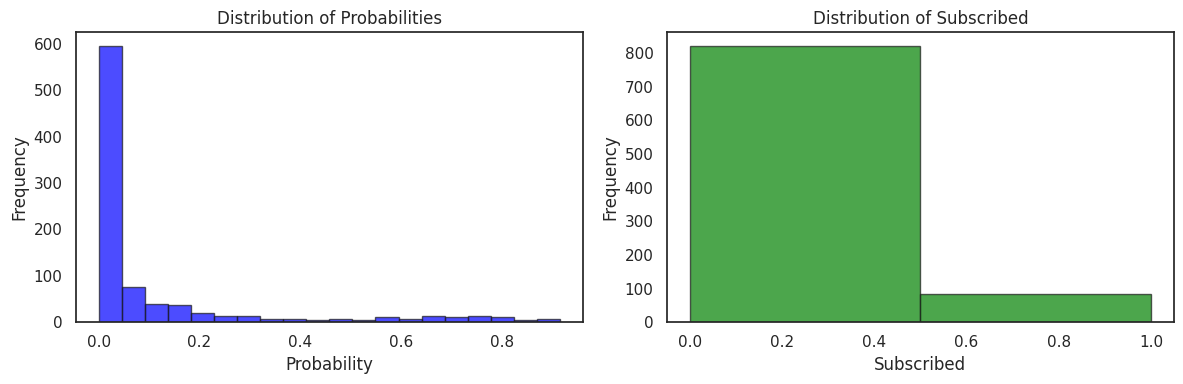

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'results_df' contains the 'Probability' and 'Subscribed' columns
# You can access the columns with results_df['Probability'] and results_df['Subscribed']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot Probability distribution
ax1.hist(results_df['Probability'], bins=20, edgecolor='k', alpha=0.7, color='blue')
ax1.set_xlabel('Probability')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Probabilities')

# Plot Subscribed distribution
ax2.hist(results_df['subscribed'], bins=2, edgecolor='k', alpha=0.7, color='green')
ax2.set_xlabel('Subscribed')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Subscribed')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Summary

## Conclusion

1. Feature Importance:
The Random Forest model identified several features that have significant importance in predicting the likelihood of a client subscribing to a term deposit. The top five influential features are: duration, balance, age, month_encoded, and day.

2. Duration Significance:
The duration of the last contact is the most critical factor in determining subscription likelihood. It accounts for approximately 29.15% of the predictive power, suggesting that longer conversations during marketing calls have a substantial impact on subscription outcomes.

3. Financial Stability Matters:
Balance is the second most important feature, indicating that a client's average yearly balance is a key factor. This suggests that clients with healthier financial situations are more likely to subscribe to a term deposit.

4. Age and Timing Considerations:
Age and temporal factors (month_encoded and day) also hold notable importance. This suggests that targeting specific age groups and timing campaigns strategically may enhance subscription rates.

5. Job, Communication, and Past Campaigns:
Job type (job_encoded), communication type (contact_encoded), and the outcome of the previous marketing campaign (poutcome_encoded) also contribute to the predictive power of the model.

## Recommendation

1. Prioritize Long Conversations:
Train call center agents to engage clients effectively, encouraging longer conversations and providing valuable information about term deposits.

2. Segment Marketing by Financial Profile:
Segment clients based on their financial stability. Focus on those with higher average yearly balances for more targeted marketing efforts.

3. Customize Campaigns by Age and Timing:
Tailor campaigns to specific age groups and time them strategically to maximize effectiveness.